In [1]:
import numpy as np
from typing import Union, Iterable, Sized, Tuple
import torch
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import matplotlib.pyplot as plt
import math
import os
import random
import logging
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torchinfo import summary

from data_processing.data_loader import *
from model.activation_layers import ExULayer, ReLULayer, LipschitzMonotonicLayer
from model.model_network import HierarchNeuralAdditiveModel
from utils.model_architecture_type import get_defult_architecture_phase1, get_defult_architecture_phase2
from training.trainer import Trainer
from utils.utils import define_device, seed_everything
from utils.model_parser import parse_args
from training.metrics import visualize_gam
import wandb



In [2]:
# wandb.login()

In [2]:
# Parsing arguments
args = parse_args()

# Set device and seed
device = define_device("auto")
print(device)

seed_everything(args.seed)

cuda


In [4]:
# args.featureNN_arch_phase1='multi_output'#'single_to_multi_output'
# args.featureNN_arch_phase2='multi_output'#'parallel_single_output'

DATA PROCESSING

In [5]:
# Generate synthetic data for Phase 1 and Phase 2
X, y_phase1, _ = SyntheticDatasetGenerator.get_synthetic_data_phase1(50000, args.in_features)
y_phase2, _ = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1)

SyntheticDataset= True
if SyntheticDataset:
    # Generate synthetic data for validation set
    X_val, y_phase1_val, _ = SyntheticDatasetGenerator.get_synthetic_data_phase1(10000, args.in_features)
    y_phase2_val, _ = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1_val)

    train_loader = SyntheticDatasetGenerator.make_loader(X, y_phase2, batch_size=args.batch_size)
    val_loader = SyntheticDatasetGenerator.make_loader(X_val, y_phase2_val, batch_size=args.batch_size)
else:
    # Initialize DataLoaderWrapper with validation split
    dataloader_wrapper = DataLoaderWrapper(X, y_phase2, val_split=args.val_split)
    # Create DataLoaders
    train_loader, val_loader = dataloader_wrapper.create_dataloaders()

# Print the size of training and validation datasets
print("Train size:", len(train_loader.dataset), "Val size:", len(val_loader.dataset))

torch.Size([50000, 10])
torch.Size([50000, 4])
torch.Size([50000, 2])
torch.Size([10000, 10])
torch.Size([10000, 4])
torch.Size([10000, 2])
Train size: 50000 Val size: 10000


# Enforce Monotonicity

In [5]:
input = X.T
print(input.shape)
print(input[0].shape)
output = y_phase2.T
print(output.shape)

matrixs = {}

for feature in range(input.size(0)):
    matrixs[feature] = torch.cat((input[feature].unsqueeze(0), output), dim=0)

# Function to sort each matrix according to the first row
def sort_matrix_by_first_row(matrix):
    # Get the sorting indices based on the first row (row 0)
    sorted_indices = torch.argsort(matrix[0, :])
    
    # Sort the matrix columns according to these indices
    sorted_matrix = matrix[:, sorted_indices]
    
    return sorted_matrix

# Sort all matrices in the list
sorted_matrices = [sort_matrix_by_first_row(matrixs[feature]) for feature in matrixs.keys()]
sorted_matrices

# Print original and sorted matrix for comparison
if False:
    for i in range(10):
        print(f"Original Matrix {i+1}:\n{matrixs[i]}")
        print(f"Sorted Matrix {i+1}:\n{sorted_matrices[i]}\n")

sorted_matrices[0].size(1)
num_features = len(sorted_matrices)
num_outputs = sorted_matrices[0].size(0)
num_exp = sorted_matrices[0].size(1)

features_diff = {}
tot_diff = 0

total_penalty = 0
for feature_matrix in sorted_matrices:
    for logits_idx in range(1, feature_matrix.size(0)):  # Iterate over logits rows
        logits_values = feature_matrix[logits_idx, :]
        diffs = logits_values[:-1] - logits_values[1:]  # Differences between consecutive values
        penalty = F.relu(diffs).sum()  # Penalize negative differences
        total_penalty += penalty
print(total_penalty)

for k in range(num_features):
    feat_diff = 0
    for j in range(1, num_outputs):
        out_vec = sorted_matrices[k][j, :]
        for i in range(num_exp-1):
            diff = F.relu(out_vec[i]-out_vec[i+1])
            feat_diff += diff
            tot_diff += diff
    
    #print(f"{k}: {feat_diff}")

print(tot_diff)

# print(sorted_matrices[0])
# tot_diff= 0
# for j in range(1,3):
#     vec = sorted_matrices[0][j, :]
#     print(vec)
#     for i in range(5-1):
#         diff = F.relu(vec[i]-vec[i+1])
#         print(diff)
#         tot_diff += diff

# tot_diff

torch.Size([10, 5])
torch.Size([5])
torch.Size([2, 5])
tensor(130.1671)
tensor(130.1671)


# Train the model

In [17]:
args.featureNN_arch_phase1 = "single_to_multi_output"
args.featureNN_arch_phase2 = "parallel_single_output"

In [18]:
args

Namespace(GAM_block_layers_type_phase1='ReLU', GAM_block_layers_type_phase2='ReLU', base_lr=0.001, batch_size=1024, clip_value=0, cycle_momentum=False, div_factor=25, early_stop_delta=0.0, early_stop_patience=30, epochs=2000, eval_every=100, featureNN_arch_phase1='single_to_multi_output', featureNN_arch_phase2='parallel_single_output', feature_dropout_phase1=0.3, feature_dropout_phase2=0.0, final_div_factor=10000.0, first_activate_layer_phase1='ReLU', first_activate_layer_phase2='LipschitzMonotonic', first_hidden_dim_phase1=64, first_hidden_dim_phase2=128, group_size_phase1=2, group_size_phase2=2, hidden_activate_layer_phase1='ReLU', hidden_activate_layer_phase2='LipschitzMonotonic', hidden_dim_phase1=[64, 32], hidden_dim_phase2=[128, 64], hidden_dropout_phase1=0.2, hidden_dropout_phase2=0.0, hierarch_net=True, in_features=10, l1_lambda_phase1=0.0, l1_lambda_phase2=0.0, l2_lambda_phase1=0.0, l2_lambda_phase2=0.0002, latent_dim=4, learning_rate=0.0035, lr_scheduler='NoScheduler', max_lr

Initialaize Model 

In [20]:
# Model definition: HierarchNeuralAdditiveModel
model = HierarchNeuralAdditiveModel(num_inputs=args.in_features,
                                    task_type= args.task_type,
                                    hierarch_net= args.hierarch_net,
                                    #phase1 - latent_features:
                                    num_units_phase1= args.first_hidden_dim_phase1,
                                    hidden_units_phase1 = args.hidden_dim_phase1,
                                    hidden_dropout_phase1 =args.hidden_dropout_phase1,
                                    feature_dropout_phase1 = args.feature_dropout_phase1,
                                    shallow_phase1 = args.shallow_phase1,
                                    first_layer_phase1 = args.first_activate_layer_phase1,
                                    hidden_layer_phase1= args.hidden_activate_layer_phase1,         
                                    latent_var_dim= args.latent_dim,
                                    featureNN_architecture_phase1= args.featureNN_arch_phase1,
                                    weight_norms_kind_phase1= args.weight_norms_kind_phase1, 
                                    group_size_phase1= args.group_size_phase1, 
                                    monotonic_constraint_phase1= args.monotonic_constraint_phase1,
                                    #phase2 - final outputs:
                                    num_units_phase2= args.first_hidden_dim_phase2,
                                    hidden_units_phase2 = args.hidden_dim_phase2,
                                    hidden_dropout_phase2 = args.hidden_dropout_phase2,
                                    feature_dropout_phase2 = args.feature_dropout_phase2,
                                    shallow_phase2 = args.shallow_phase2,
                                    first_layer_phase2 = args.first_activate_layer_phase2,
                                    hidden_layer_phase2 = args.hidden_activate_layer_phase2,          
                                    output_dim = args.output_dim,
                                    featureNN_architecture_phase2 = args.featureNN_arch_phase2,
                                    weight_norms_kind_phase2 = args.weight_norms_kind_phase2, 
                                    group_size_phase2 = args.group_size_phase2, 
                                    monotonic_constraint_phase2 = args.monotonic_constraint_phase2
                                    ).to(device)

# model = HierarchNeuralAdditiveModel(num_inputs=10, 
#                                     output_dim = 2, 
#                                     latent_var_dim = 4, 
#                                     task_type = 'regression', 
#                                     hierarch_net = True,
#                                     first_layer_phase1 = 'ReLU',
#                                     hidden_layer_phase1 = 'ReLU',
#                                     first_layer_phase2 = 'LipschitzMonotonic',
#                                     hidden_layer_phase2 = 'LipschitzMonotonic',
#                                     shallow_phase1 = False,
#                                     shallow_phase2 = False
#                                     ).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

if 0:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.numel()} parameters')
if 0:
    print(summary(model,input_size=(1, 10)))

Number of parameters: 465160


Train the model

In [8]:
# Initialize the Trainer class
trainer = Trainer(
        model=model,
        optimizer=args.optimizer,
        loss_function=None,
        lr_scheduler=args.lr_scheduler, 
        scheduler_params=None,
        eval_metric=None, 
        epochs=args.epochs, 
        batch_size=args.batch_size, 
        learning_rate=args.learning_rate, 
        weight_decay=args.weight_decay, 
        l1_lambda_phase1=args.l1_lambda_phase1,
        l1_lambda_phase2=args.l1_lambda_phase2,
        l2_lambda_phase1=args.l2_lambda_phase1,
        l2_lambda_phase2=args.l2_lambda_phase2,
        monotonicity_lambda=0.00001,
        eval_every=10,
        early_stop_delta=args.early_stop_delta,
        early_stop_patience=args.early_stop_patience,
        clip_value=args.clip_value,
        device_name="auto"
)

# Run the training phase
train_loss_history, val_loss_history = trainer.train(args, train_loader)

  0%|          | 0/2000 [00:00<?, ?it/s]

logits shape: torch.Size([5, 2])
latent_features shape: torch.Size([5, 4])
input: tensor([0.2169, 0.6838, 1.3239, 2.3069, 2.4086], device='cuda:0',
       grad_fn=<SliceBackward0>)
output 1: tensor([0.1056, 0.1034, 0.1034, 0.1073, 0.1066], device='cuda:0',
       grad_fn=<SliceBackward0>)
diff tensor([ 2.1912e-03,  1.0788e-05, -3.9306e-03,  7.5728e-04], device='cuda:0',
       grad_fn=<SubBackward0>)
input: tensor([0.2169, 0.6838, 1.3239, 2.3069, 2.4086], device='cuda:0',
       grad_fn=<SliceBackward0>)
output 2: tensor([-0.0115, -0.0112, -0.0113, -0.0106, -0.0111], device='cuda:0',
       grad_fn=<SliceBackward0>)
diff tensor([-0.0003,  0.0001, -0.0007,  0.0005], device='cuda:0',
       grad_fn=<SubBackward0>)
input: tensor([-2.1573, -0.5277, -0.4696, -0.0684,  0.8825], device='cuda:0',
       grad_fn=<SliceBackward0>)
output 1: tensor([0.1034, 0.1073, 0.1056, 0.1066, 0.1034], device='cuda:0',
       grad_fn=<SliceBackward0>)
diff tensor([-0.0039,  0.0017, -0.0010,  0.0032], device='

  0%|          | 0/2000 [00:01<?, ?it/s]

Epoch 0 | Total Loss: 140.50745


Error: You must call wandb.init() before wandb.log()

In [45]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

<ipython-input-45-92606a11566f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


RuntimeError: Error(s) in loading state_dict for HierarchNeuralAdditiveModel:
	Missing key(s) in state_dict: "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.output_layer.bias", "NAM_output.feature_nns.0.feature_nns.0.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.0.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.0.output_layer.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.0.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.0.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.output_layer.bias", "NAM_output.feature_nns.0.feature_nns.1.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.0.feature_nns.1.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.0.feature_nns.1.output_layer.layer.0.bias", "NAM_output.feature_nns.0.feature_nns.1.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.0.feature_nns.1.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.output_layer.bias", "NAM_output.feature_nns.1.feature_nns.0.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.0.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.0.output_layer.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.0.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.0.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.output_layer.bias", "NAM_output.feature_nns.1.feature_nns.1.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.1.feature_nns.1.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.1.feature_nns.1.output_layer.layer.0.bias", "NAM_output.feature_nns.1.feature_nns.1.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.1.feature_nns.1.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.output_layer.bias", "NAM_output.feature_nns.2.feature_nns.0.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.0.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.0.output_layer.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.0.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.0.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.output_layer.bias", "NAM_output.feature_nns.2.feature_nns.1.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.2.feature_nns.1.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.2.feature_nns.1.output_layer.layer.0.bias", "NAM_output.feature_nns.2.feature_nns.1.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.2.feature_nns.1.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.output_layer.bias", "NAM_output.feature_nns.3.feature_nns.0.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.0.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.0.output_layer.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.0.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.0.output_layer.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.layer.0.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.output_layer.bias", "NAM_output.feature_nns.3.feature_nns.1.output_layer.lipschitz_layer.bias", "NAM_output.feature_nns.3.feature_nns.1.output_layer.lipschitz_layer.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.output_layer.lipschitz_layer.parametrizations.weight.original", "NAM_output.feature_nns.3.feature_nns.1.output_layer.layer.0.bias", "NAM_output.feature_nns.3.feature_nns.1.output_layer.layer.0.lipschitz_const", "NAM_output.feature_nns.3.feature_nns.1.output_layer.layer.0.parametrizations.weight.original". 
	size mismatch for NAM_output.feature_nns.0.feature_nns.0.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.0.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.0.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.0.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.1.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.1.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.1.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.0.feature_nns.1.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.0.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.0.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.0.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.0.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.1.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.1.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.1.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.1.feature_nns.1.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.0.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.0.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.0.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.0.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.1.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.1.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.1.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.2.feature_nns.1.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.0.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.0.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.0.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.0.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.1.hidden_layers.0.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([128, 128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.1.hidden_layers.1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.1.hidden_layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for NAM_output.feature_nns.3.feature_nns.1.output_layer.weight: copying a param with shape torch.Size([1, 32]) from checkpoint, the shape in current model is torch.Size([64, 1]).

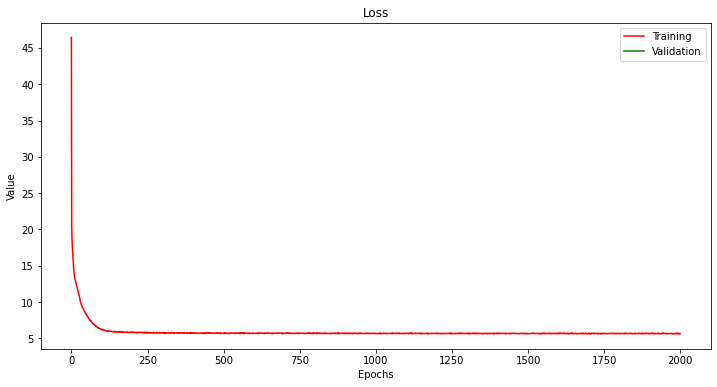

In [12]:
train_loss_history_np = [loss for loss in train_loss_history]
val_loss_history_np = [loss for loss in val_loss_history]

plt.figure(figsize=(12, 6))

plt.plot(train_loss_history_np, color='r', label='Training')
plt.plot(val_loss_history_np, color='g', label='Validation')

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Loss")

plt.legend()
plt.show()

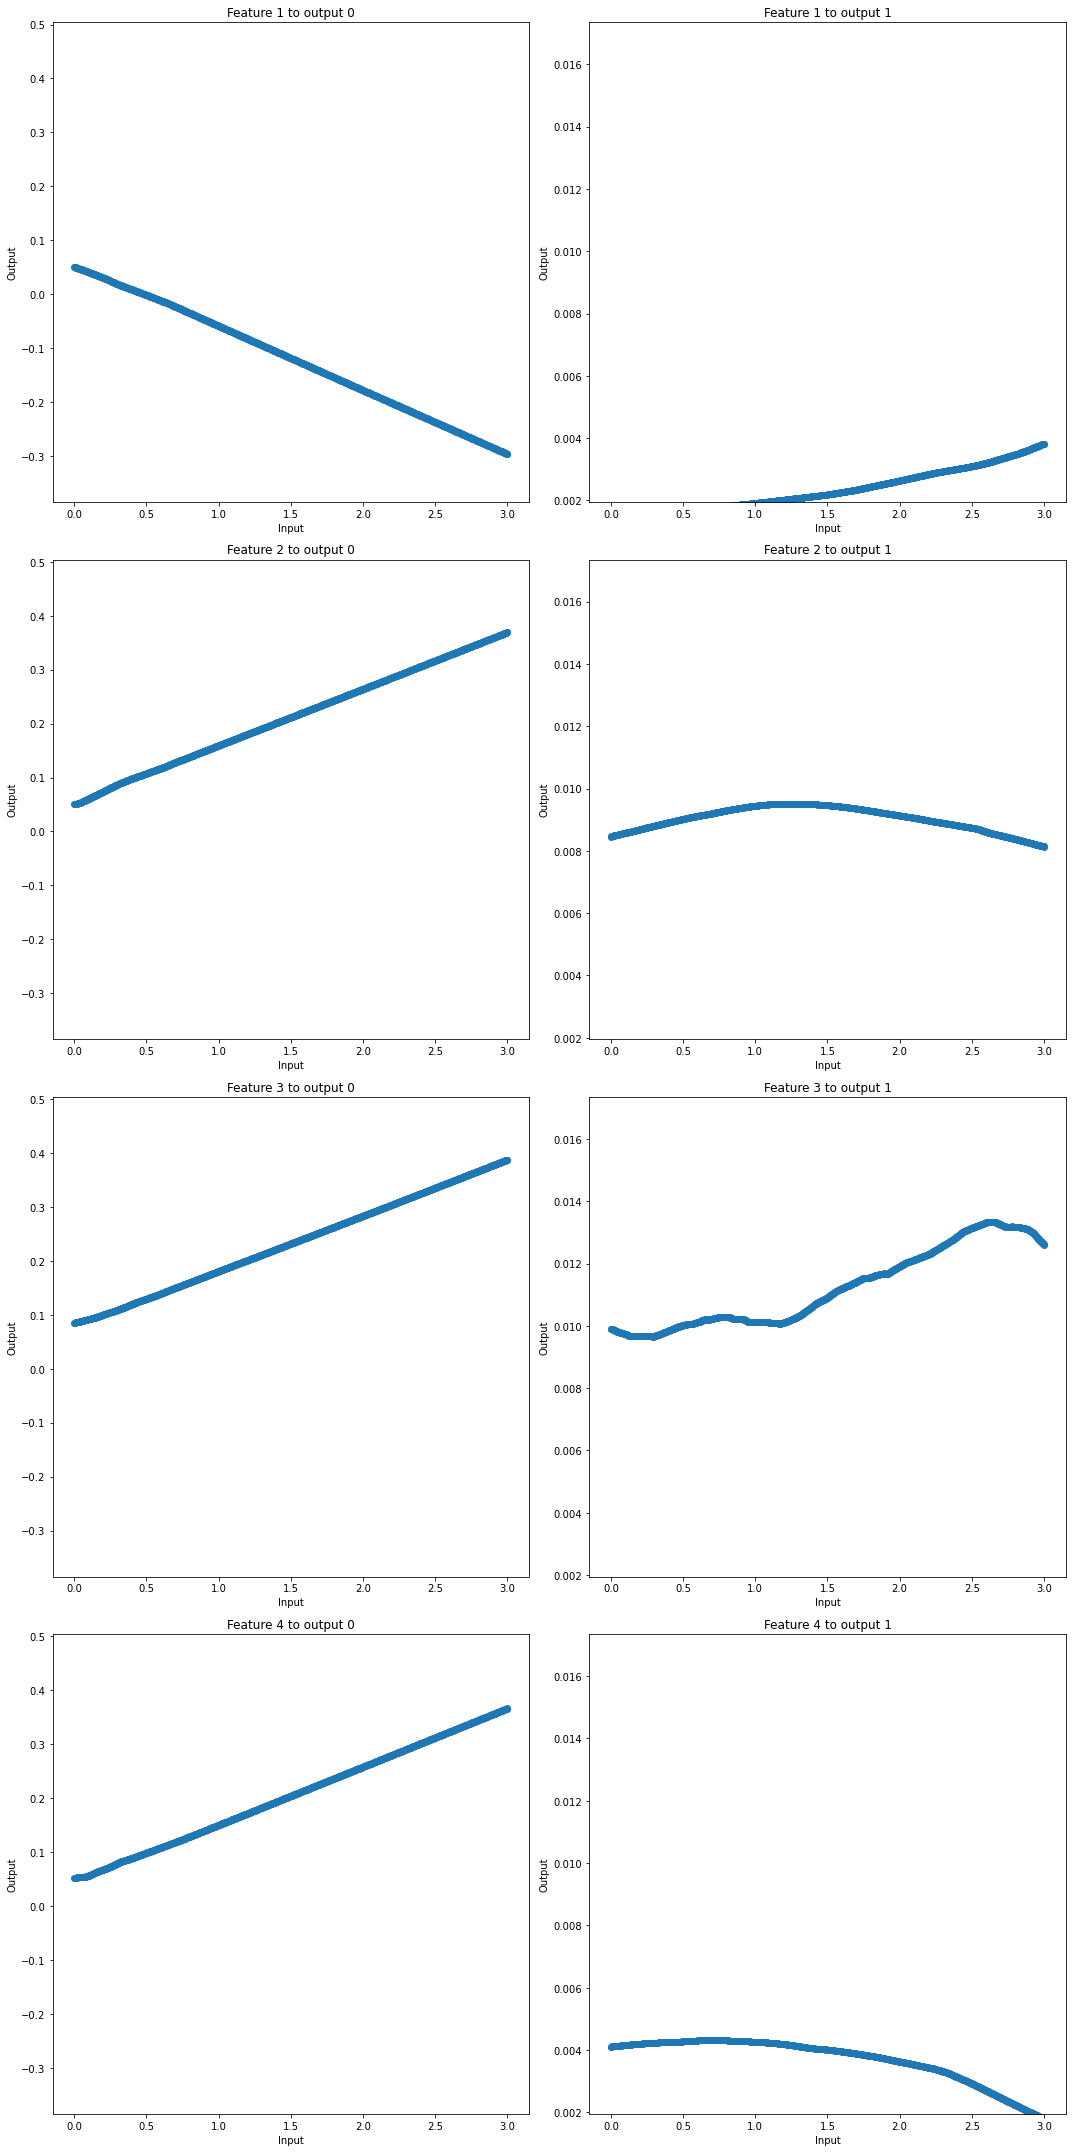

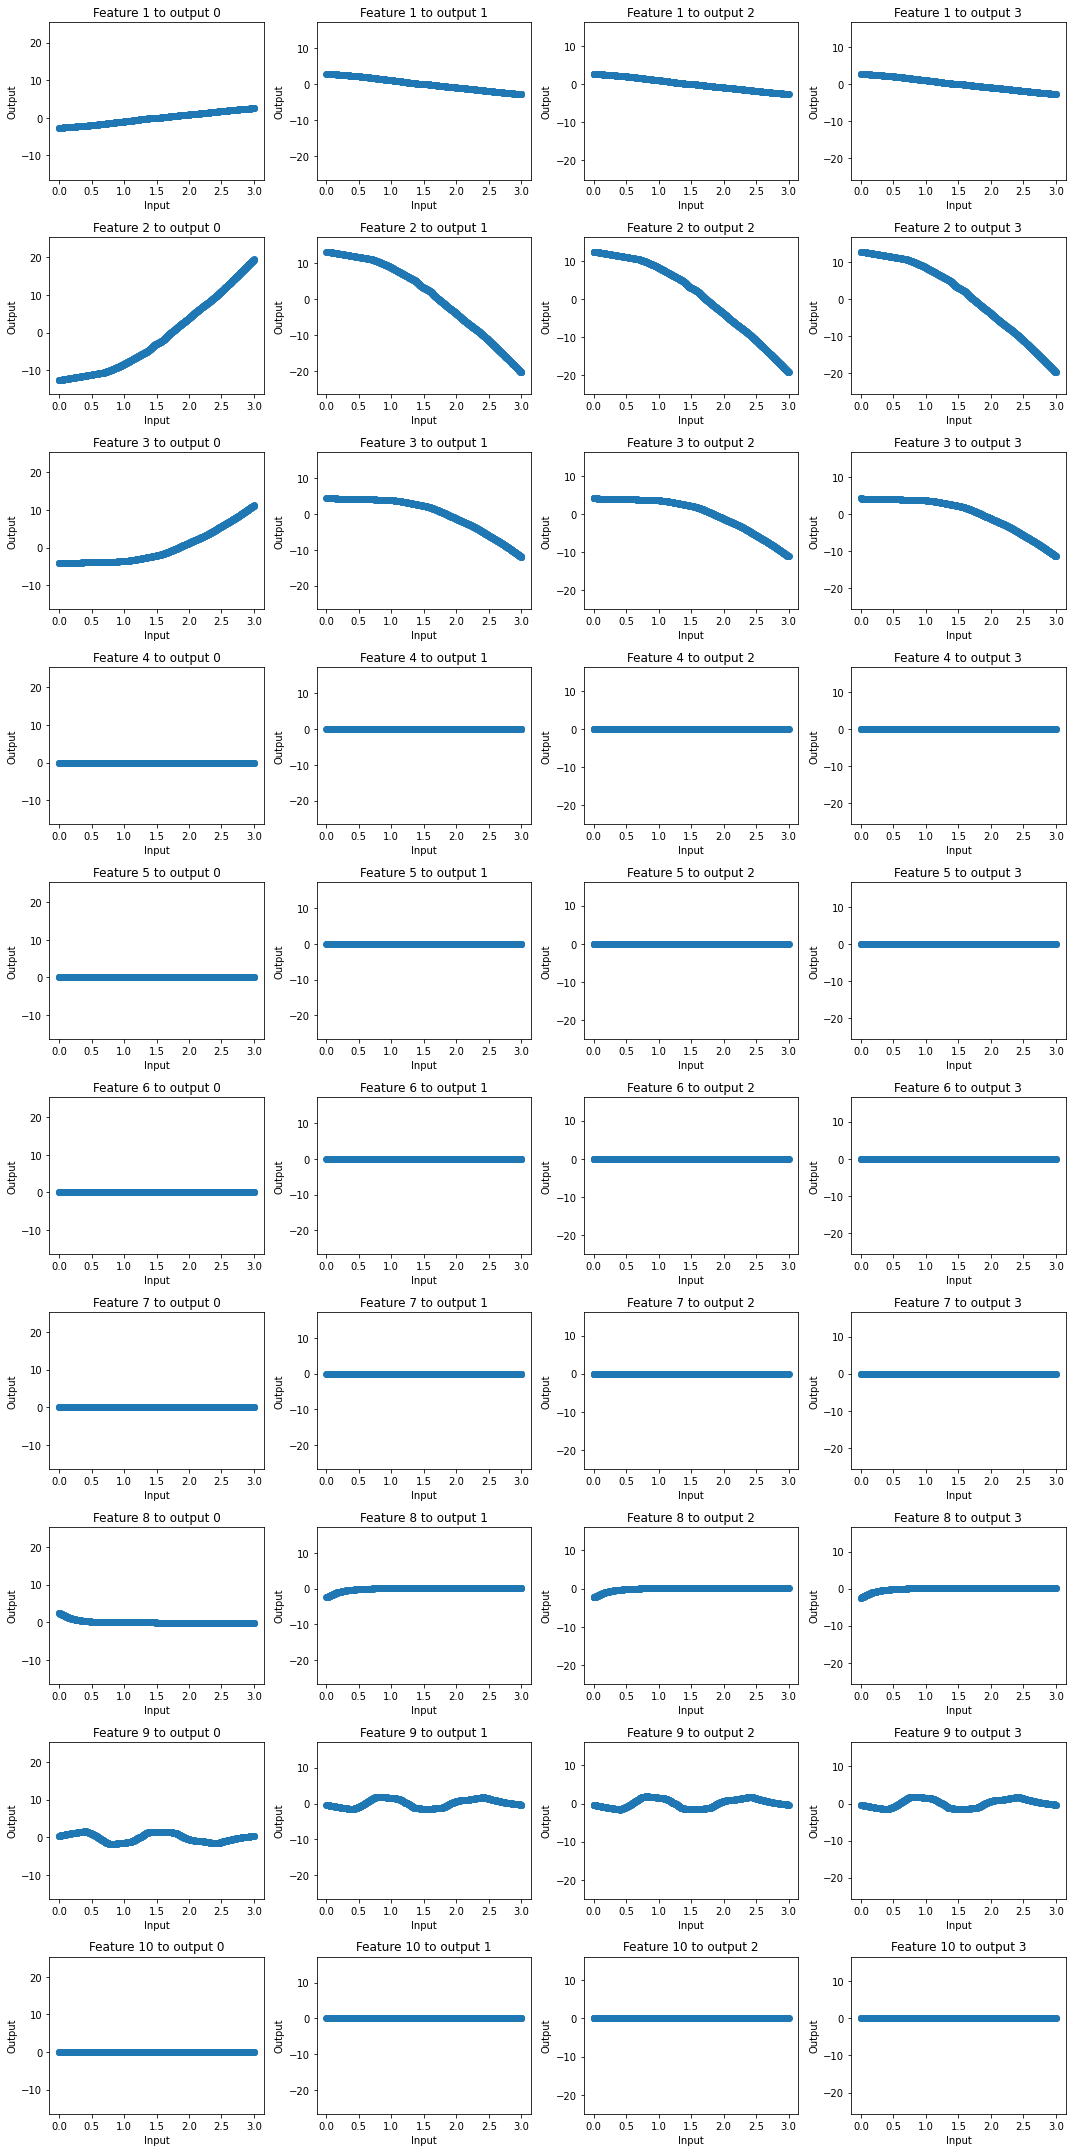

In [10]:
# Generate input values for plotting
x_values = torch.linspace(0, 3, 1000).reshape(-1, 1)  # 100 points between -1 and 1

input_dim = args.latent_dim
output_dim = args.output_dim
visualize_gam(model, x_values.to(device), input_dim, output_dim, vis_lat_features = False)

input_dim = args.in_features
output_dim = args.latent_dim
visualize_gam(model, x_values.to(device), input_dim, output_dim, vis_lat_features = True)

# Dataset

In [45]:
def get_synthetic_data_phase1(num_exp=10, in_features=10):
    # Simulate independent variables, x0,...,x4 from a Uniform distribution on [−1, 1]
    X_uniform = Uniform(-1, 1).sample((num_exp, in_features-5))
    
    # Simulate features x5 and x6 from a Normal distribution with mean=0 and std=1
    X_normal = torch.normal(0, 1, (num_exp, 5))
    
    # Combine the uniform and normal features
    X = torch.cat([X_uniform, X_normal], dim=1)
    print(X.shape)
    
    # creating y_1
    y_1 = X[:, 0] + 0.5*(3*(X[:, 1]**2)-1) + 0.5*(X[:, 2]**3)
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = (1/3) * torch.log(100 * X[:, 5].abs()) + torch.sin(5 * X[:, 6])
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # creating y_3
    y_3 = -(3/4) * torch.exp(-4 * X[:, 7].abs()) + torch.cos(5 * X[:, 8])
    y_3 = y_3.reshape(-1, 1)
    
    # creating y_4
    y_4 = torch.sin(5 * X[:, 5]) + 0.5*(3*(X[:, 2]**2)-1)  
    y_4 = y_4.reshape(-1, 1)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2, y_3, y_4], dim=1)
    print(y.shape)
    
    return X, y


def get_synthetic_data_phase2(X_input):
    
    # creating y_1
    y_1 = 4*X_input[:, 0] + 0.5*X_input[:, 1]
    y_1 = y_1.reshape(-1, 1)
    #print(y_1.shape)
    
    # creating y_2
    y_2 = (1/3) * X_input[:, 2] + 5 * X_input[:, 3]
    y_2 = y_2.reshape(-1, 1)
    #print(y_2.shape)
    
    # Stack all y_i to form the final target matrix
    y = torch.cat([y_1, y_2], dim=1)
    print(y.shape)
    
    return y


def make_loader(X, y, batch_size):
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

In [46]:
X, y = get_synthetic_data_phase1(num_exp=1, in_features=10)
Y = get_synthetic_data_phase2(y)

torch.Size([1, 10])
torch.Size([1, 4])
torch.Size([1, 2])


# Model architecture

In [47]:
def truncated_normal_(tensor, mean: float = 0., std: float = 1.):
    """
    Initializes a tensor with values from a truncated normal distribution
    """
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)

# ActivationLayer Class
class ActivationLayer(torch.nn.Module):
    """
    Abstract base class for layers with weights and biases
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__()
        
        self.weight = torch.nn.Parameter(torch.empty((in_features, out_features)))
        self.bias = torch.nn.Parameter(torch.empty(in_features))

    def forward(self, x):
        raise NotImplementedError("abstract method called")


class ExULayer(ActivationLayer):
    """
    Custom layer using exponential activation with weight and bias initialization
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__(in_features, out_features)
        
        truncated_normal_(self.weight, mean=4.0, std=0.5)
        truncated_normal_(self.bias, std=0.5)

    def forward(self, x): 
        exu = (x - self.bias) @ torch.exp(self.weight)
        output = torch.clip(exu, 0, 1)
        
        if 0:
            print('ExULayer_weights:', self.weight.detach().cpu().numpy())
            print('ExULayer Normalization L1\n:', torch.linalg.norm(self.weight.t(), 1, dim=0))
            print('ExULayer Normalization L2\n:',torch.linalg.norm(self.weight.t(), 2, dim=0))
        
        return output


class ReLULayer(ActivationLayer):
    """
    Custom layer using ReLU activation with Xavier weight initialization
    """
    def __init__(self,
                 in_features: int,
                 out_features: int):
        super().__init__(in_features, out_features)
        
        torch.nn.init.xavier_uniform_(self.weight)
        truncated_normal_(self.bias, std=0.5)

    def forward(self, x):
        output = F.relu((x - self.bias) @ self.weight)
        
        if 0:
            print('ReLULayer_weights:', self.weight.detach().cpu().numpy())
            print('ReLULayer Normalization L1:\n', torch.linalg.norm(self.weight.t(), 1, dim=0))
            print('ReLULayer Normalization L2:\n',torch.linalg.norm(self.weight.t(), 2, dim=0))
        
        return output


# FeatureNN Class
class FeatureNN(torch.nn.Module):
    """
    Neural network for individual features
    """
    def __init__(self,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 dropout: float = .5,
                 output_dim: int = 1,
                 ):
        super().__init__()
        
        # First (shallow) layer
        self.shallow_layer = shallow_layer(1, shallow_units)
        
        # Hidden layers
        self.hidden_layers = torch.nn.ModuleList()
        in_units = shallow_units
        for out_units in hidden_units:
            self.hidden_layers.append(hidden_layer(in_units, out_units))
            in_units = out_units  # Update in_units to the output of the last layer
        
        # Dropout layer
        self.dropout = torch.nn.Dropout(p=dropout)
        
        # Output linear layer
        self.output_layer = torch.nn.Linear(in_units, output_dim, bias=False)
        torch.nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, x):
        x = x.unsqueeze(1)
        
        # Pass through the shallow layer
        x = self.shallow_layer(x)
        #x = self.dropout(x)
        
        # Pass through each hidden layer with dropout
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.dropout(x)
            
        # Final output layer
        x = self.output_layer(x)
        
        return x


# Neural Additive Model (NAM) Class
class NeuralAdditiveModel(torch.nn.Module):
    """
    Combines multiple feature networks, each processing one feature, with dropout and bias
    """
    def __init__(self,
                 input_size: int,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 hidden_dropout: float = 0.,
                 feature_dropout: float = 0.,
                 output_dim: int = 1,
                 ):
        super().__init__()
        
        self.input_size = input_size

        if isinstance(shallow_units, list):
            assert len(shallow_units) == input_size
        elif isinstance(shallow_units, int):
            shallow_units = [shallow_units for _ in range(input_size)]

        self.feature_nns = torch.nn.ModuleList([
            FeatureNN(shallow_units=shallow_units[i],
                      hidden_units=hidden_units,
                      shallow_layer=shallow_layer,
                      hidden_layer=hidden_layer,
                      dropout=hidden_dropout,
                      output_dim=output_dim)
            for i in range(input_size)
        ])
        self.feature_dropout = torch.nn.Dropout(p=feature_dropout)
        self.bias = torch.nn.Parameter(torch.zeros(output_dim))
        
    def forward(self, x):
        # Collect outputs from each feature network
        FeatureNN_out = self._feature_nns(x)
        
        # Concatenates a sequence of tensors along the latent features dimension 
        f_out = torch.stack(FeatureNN_out, dim=-1)
        
        # Sum across features and add bias
        f_out = self.feature_dropout(f_out)
        outputs = f_out.sum(axis=-1) + self.bias
        
        if 0:
            print('final output', outputs)
            print('f_out', f_out)
        return outputs, f_out

    def _feature_nns(self, x):
        return [self.feature_nns[i](x[:, i]) for i in range(self.input_size)]
    

# Hirarchical Neural Additive Model Class
class HierarchNeuralAdditiveModel(torch.nn.Module):
    """
    Hierarch Neural Additive Model
    """
    def __init__(self,
                 input_size: int,
                 shallow_units: int,
                 hidden_units: Tuple = (),
                 shallow_layer: ActivationLayer = ExULayer,
                 hidden_layer: ActivationLayer = ReLULayer,
                 hidden_dropout: float = 0.,
                 feature_dropout: float = 0.,
                 latent_feature_dropout: float = 0.,
                 latent_var_dim: int = 1,
                 output_dim: int = 1,
                 ):
        super().__init__()

        self.NAM_features = NeuralAdditiveModel(input_size=input_size,
                                shallow_units= shallow_units,
                                hidden_units= hidden_units,
                                shallow_layer= shallow_layer,
                                hidden_layer= hidden_layer,
                                hidden_dropout= hidden_dropout,
                                feature_dropout= feature_dropout,
                                output_dim = latent_var_dim,
                                )
       

        self.NAM_output = NeuralAdditiveModel(input_size=latent_var_dim,
                                shallow_units= shallow_units,
                                hidden_units= hidden_units,
                                shallow_layer= shallow_layer,
                                hidden_layer= hidden_layer,
                                hidden_dropout= hidden_dropout,
                                feature_dropout= latent_feature_dropout,
                                output_dim = output_dim,
                                )

    def forward(self, x):
        
        latent_outputs, f_out = self.NAM_features(x)

        outputs, lat_f_out = self.NAM_output(latent_outputs)
       
         # Apply softmax to get class probabilities
#         outputs = torch.softmax(outputs, dim=-1)

        if 0:
            print('x:', x.shape)
            print('latent_outputs:',latent_outputs.shape)
            print('f_out:',f_out.shape)
            print('outputs:',outputs.shape)
            print('lat_f_out:',lat_f_out.shape)  
            
        return outputs, lat_f_out

# Loss

In [48]:
# Loss function for regression
def feature_loss(fnn_out, lambda_=0.):
    return lambda_ * (fnn_out ** 2).sum() / fnn_out.shape[1]

def penalized_mse(logits, truth, fnn_out, feature_penalty=0.0):
    feat_loss = feature_loss(fnn_out, feature_penalty)
    mse_loss = F.mse_loss(logits.view(-1), truth.view(-1))
    loss = mse_loss+feat_loss
    return loss

def l1_penalty(params, l1_lambda):
    l1_norm =  torch.stack([torch.linalg.norm(p, 1) for p in params], dim=0).sum()
    return l1_lambda*l1_norm

def l2_penalty(params, l1_lambda):
    l2_norm =  torch.stack([torch.linalg.norm(p, 2) for p in params], dim=0).sum()
    return l1_lambda*l2_norm

# Model training

In [49]:
def train(model, loader, criterion, optimizer, config):
    
    # Run training and track with wandb
#    total_batches = len(loader) * config['epochs']
#    batch_ct = 0
    loss_history = []

    for epoch in tqdm(range(config['epochs'])):
        epoch_loss_history = []
        for _, (X, y) in enumerate(loader):
            loss = train_batch(X, y, model, optimizer, criterion)
#            batch_ct += 1
            epoch_loss_history.append(loss)
#             # Report metrics every 5th batch
#             if ((batch_ct + 1) % 5) == 0:
#                 print(f"Epoch {epoch} | Batch {batch_ct + 1} | Total Loss: {loss:.5f}")

        avg_loss = sum(epoch_loss_history) / len(loader)
        loss_history.append(avg_loss)
    
        if epoch%100==0:
            print(f"Epoch {epoch} | Total Loss: {avg_loss:.5f}")
        
    return loss_history
        
def train_batch(X, y, model, optimizer, criterion):    
    X, y = X.to(device), y.to(device)
    # Forward pass
    logits, fnns_out = model(X)
    loss = criterion(logits, y, fnns_out, feature_penalty=0.0001)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()
    
    if 0:
        print('predict outputs shape:',logits.shape)
        print('true outputs shape:',y.shape)
        print('fnns_out shape:',fnns_out.shape)

    return loss

# Define the Experiment

In [50]:
# define experiment
config = dict(
    epochs=2000, #100
    batch_size=1024, #128
    learning_rate=0.0035,
    weight_decay=0.0001,
    num_exp = 5000,
    in_features = 10,
    shallow_units=20, #50
    hidden_units=(64, 64, 32), #(100, 20)
    feature_dropout=0.2,
    latent_feature_dropout=0.2,
    hidden_dropout=0.2,
    latent_dim=4,
    output_dim=2,
    seed=42,
    dataset="Uniform_distribution",
    architecture="multi_output_NAM")

In [52]:
def make(config):
    
    seed_everything(seed=config['seed'])
    
    # Make the data
    X, y = get_synthetic_data_phase1(num_exp=config['num_exp'], in_features=config['in_features'])
    Y = get_synthetic_data_phase2(y)

    train_loader = make_loader(X, Y, batch_size=config['batch_size'])

    # Make the model
    model = HierarchNeuralAdditiveModel(input_size= config['in_features'],
                     shallow_units= config['shallow_units'],
                     hidden_units= config['hidden_units'],
                     shallow_layer = ExULayer,
                     hidden_layer = ReLULayer,
                     hidden_dropout = config['hidden_dropout'],
                     feature_dropout = config['feature_dropout'],
                     latent_feature_dropout = config['latent_feature_dropout'],
                     latent_var_dim = config['latent_dim'], 
                     output_dim = config['output_dim'],     
                     ).to(device)
    
#     model = NeuralAdditiveModel(input_size= config['in_features'],
#                      shallow_units= config['shallow_units'],
#                      hidden_units= config['hidden_units'],
#                      shallow_layer = ExULayer,
#                      hidden_layer = ReLULayer,
#                      hidden_dropout = config['hidden_dropout'],
#                      feature_dropout = config['feature_dropout'],
#                      output_dim = config['latent_dim'],           
#                      ).to(device)
    
    # Make the loss and optimizer
    criterion = penalized_mse
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'],
                                )
    
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.995, step_size=1)
    
    return model, train_loader, criterion, optimizer

# Run

In [ ]:
# make the model, data, and optimization problem
model, train_loader, criterion, optimizer = make(config)
model

  0%|                                                                                     | 1/2000 [00:00<25:59,  1.28it/s]

Epoch 0 | Total Loss: 15.32216


  5%|████▏                                                                              | 101/2000 [01:08<21:56,  1.44it/s]

Epoch 100 | Total Loss: 13.30928


 10%|████████▎                                                                          | 201/2000 [02:18<21:00,  1.43it/s]

Epoch 200 | Total Loss: 13.28039


 15%|████████████▍                                                                      | 301/2000 [03:30<20:38,  1.37it/s]

Epoch 300 | Total Loss: 13.27775


 20%|████████████████▋                                                                  | 401/2000 [04:51<23:59,  1.11it/s]

Epoch 400 | Total Loss: 13.27909


 25%|███████████████████                                                         | 501/2000 [64:52:57<47:13:35, 113.42s/it]

Epoch 500 | Total Loss: 13.26938


 30%|████████████████████████                                                        | 601/2000 [64:55:29<29:05,  1.25s/it]

Epoch 600 | Total Loss: 13.26983


 35%|████████████████████████████                                                    | 701/2000 [64:58:13<47:37,  2.20s/it]

Epoch 700 | Total Loss: 13.27388


 40%|████████████████████████████████                                                | 801/2000 [65:00:46<33:18,  1.67s/it]

Epoch 800 | Total Loss: 13.27215


 45%|████████████████████████████████████                                            | 901/2000 [65:03:11<23:54,  1.31s/it]

Epoch 900 | Total Loss: 13.27532


 50%|███████████████████████████████████████▌                                       | 1001/2000 [65:05:41<22:31,  1.35s/it]

Epoch 1000 | Total Loss: 13.29069


 55%|███████████████████████████████████████████▍                                   | 1101/2000 [65:08:12<23:40,  1.58s/it]

Epoch 1100 | Total Loss: 13.26554


 60%|███████████████████████████████████████████████▍                               | 1201/2000 [65:10:45<21:37,  1.62s/it]

Epoch 1200 | Total Loss: 13.27372


 65%|███████████████████████████████████████████████████▍                           | 1301/2000 [65:13:30<20:10,  1.73s/it]

Epoch 1300 | Total Loss: 13.26860


 70%|███████████████████████████████████████████████████████▎                       | 1401/2000 [65:16:27<16:22,  1.64s/it]

Epoch 1400 | Total Loss: 13.28473


 75%|███████████████████████████████████████████████████████████▎                   | 1501/2000 [65:19:24<17:59,  2.16s/it]

Epoch 1500 | Total Loss: 13.27748


 80%|███████████████████████████████████████████████████████████████▏               | 1601/2000 [65:22:33<15:26,  2.32s/it]

Epoch 1600 | Total Loss: 13.28720


 85%|███████████████████████████████████████████████████████████████████▏           | 1701/2000 [65:25:40<08:45,  1.76s/it]

Epoch 1700 | Total Loss: 13.28268


 90%|███████████████████████████████████████████████████████████████████████▏       | 1801/2000 [65:28:59<06:01,  1.82s/it]

Epoch 1800 | Total Loss: 13.28110


 95%|███████████████████████████████████████████████████████████████████████████    | 1901/2000 [65:32:18<03:19,  2.01s/it]

Epoch 1900 | Total Loss: 13.28419


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [65:35:52<00:00, 118.08s/it]


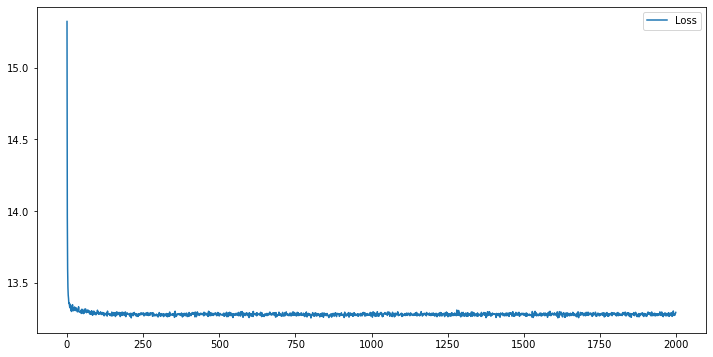

In [54]:
# and use them to train the model
loss_history = train(model, train_loader, criterion, optimizer, config)
loss_history_np = [loss.detach().cpu().numpy() for loss in loss_history]

plt.figure(figsize=(12, 6))
plt.plot(loss_history_np)
plt.legend(['Loss'])
plt.show()

# Visualaize shape functions

In [40]:
def get_shape_functions(model, args):
    # Generate input values for plotting
    x_values = torch.linspace(0, 3, 1000).reshape(-1, 1)  # 100 points between -1 and 1

    input_dim = args.latent_dim
    output_dim = args.output_dim
    visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = False)

    input_dim = args.in_features
    output_dim = args.latent_dim
    visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = True)
    return

def visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = False):
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get the device model is on

    x_values = x_values.to(device)
    
    # Plot learned functions
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15,30))

    feature_output_max = {} 
    feature_output_min = {}

    for j in range(output_dim):
        feature_output_max[f'output_{j}'] = []
        feature_output_min[f'output_{j}'] = []

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:          
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                feature_output_max[f'output_{j}'].append(max(feature_output)) 
                feature_output_min[f'output_{j}'].append(min(feature_output))

    for i in range(input_dim):
        with torch.no_grad(): 
            for j in range(output_dim):
                ax1 = axes[i, j]
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:          
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    # plot without hirarchical model
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Feature {i+1}')
                ax1.set_title(f'Feature {i+1} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')
                #ax1.set_ylim([min(feature_output_min[f'output_{j}'])*1.3, max(feature_output_max[f'output_{j}'])*1.3])

    plt.tight_layout()
    plt.show()
    return

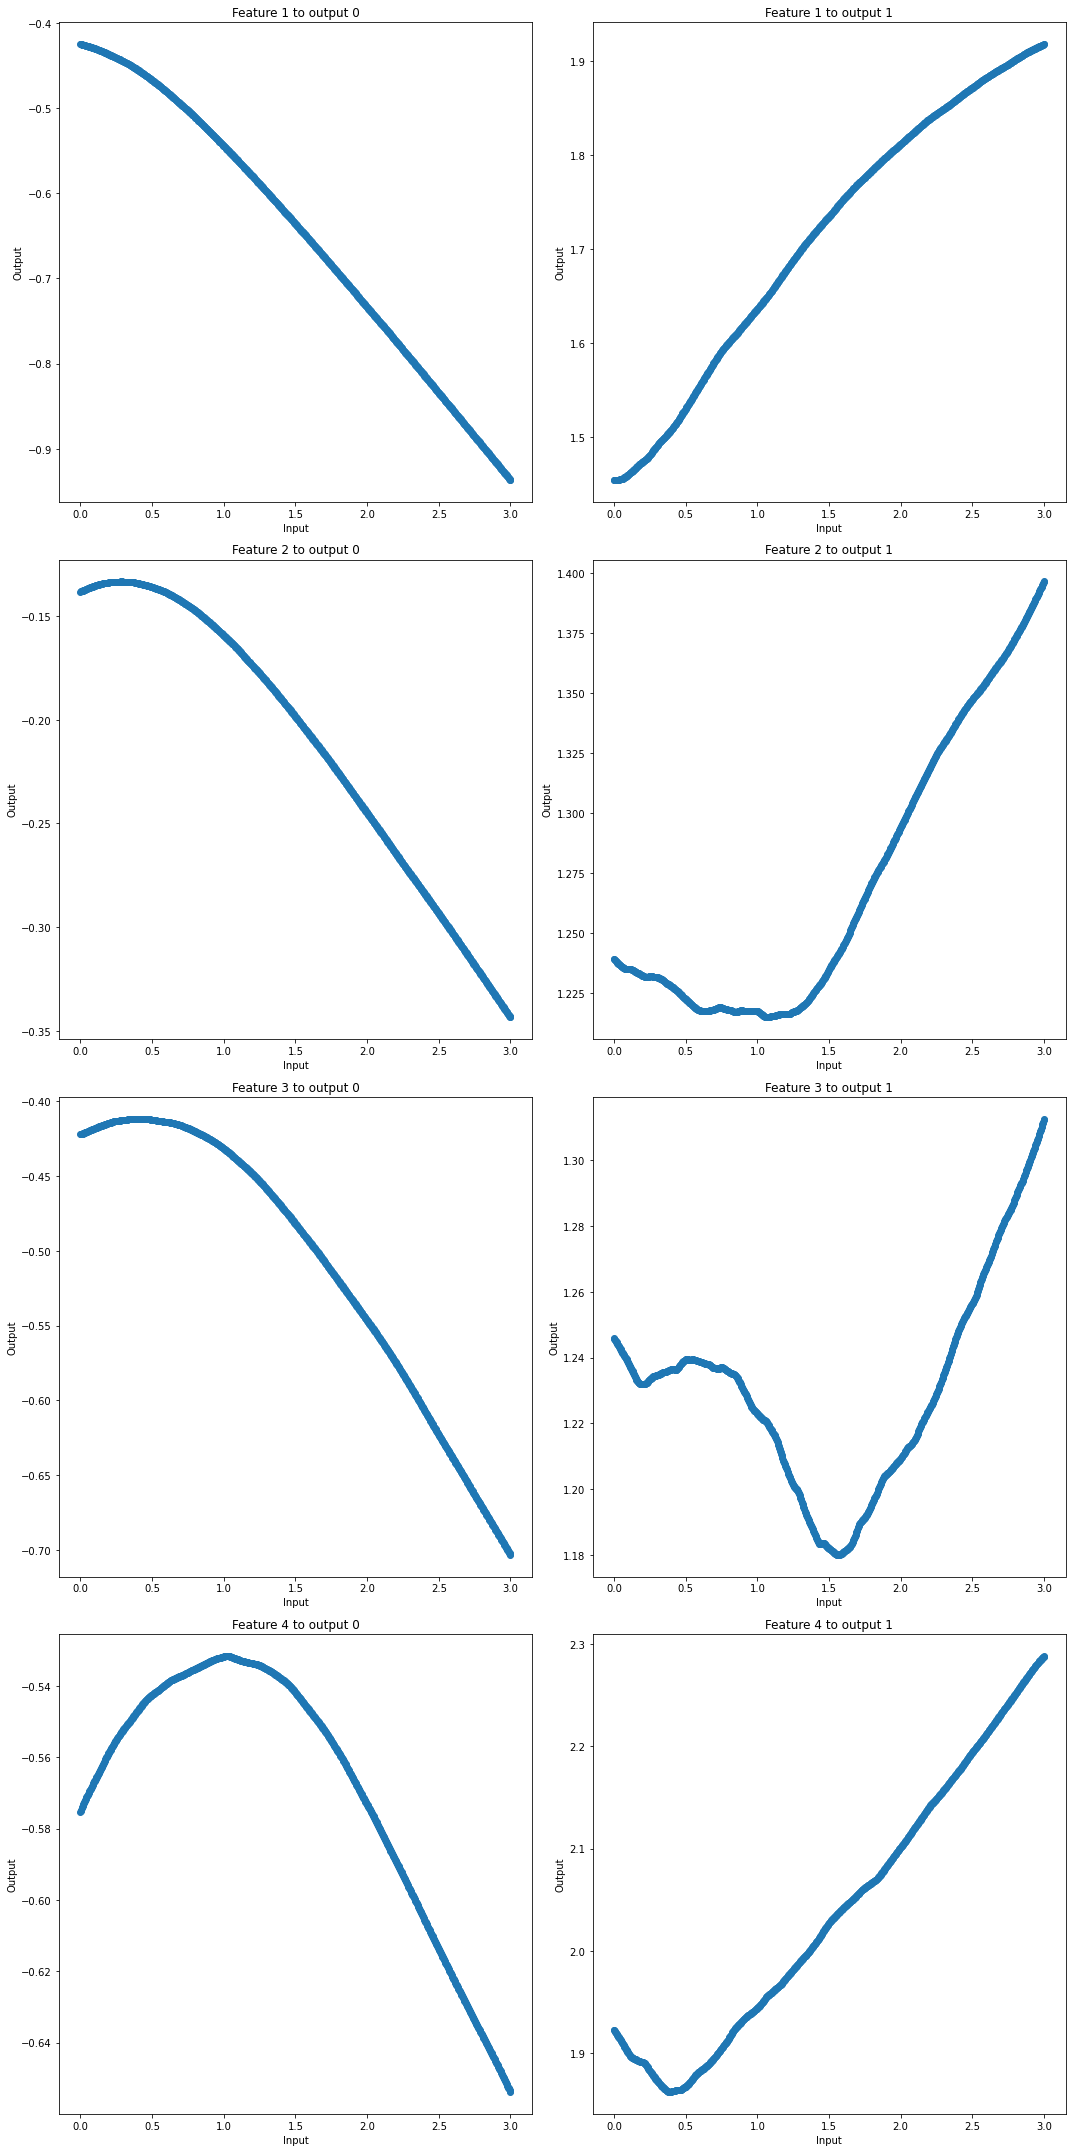

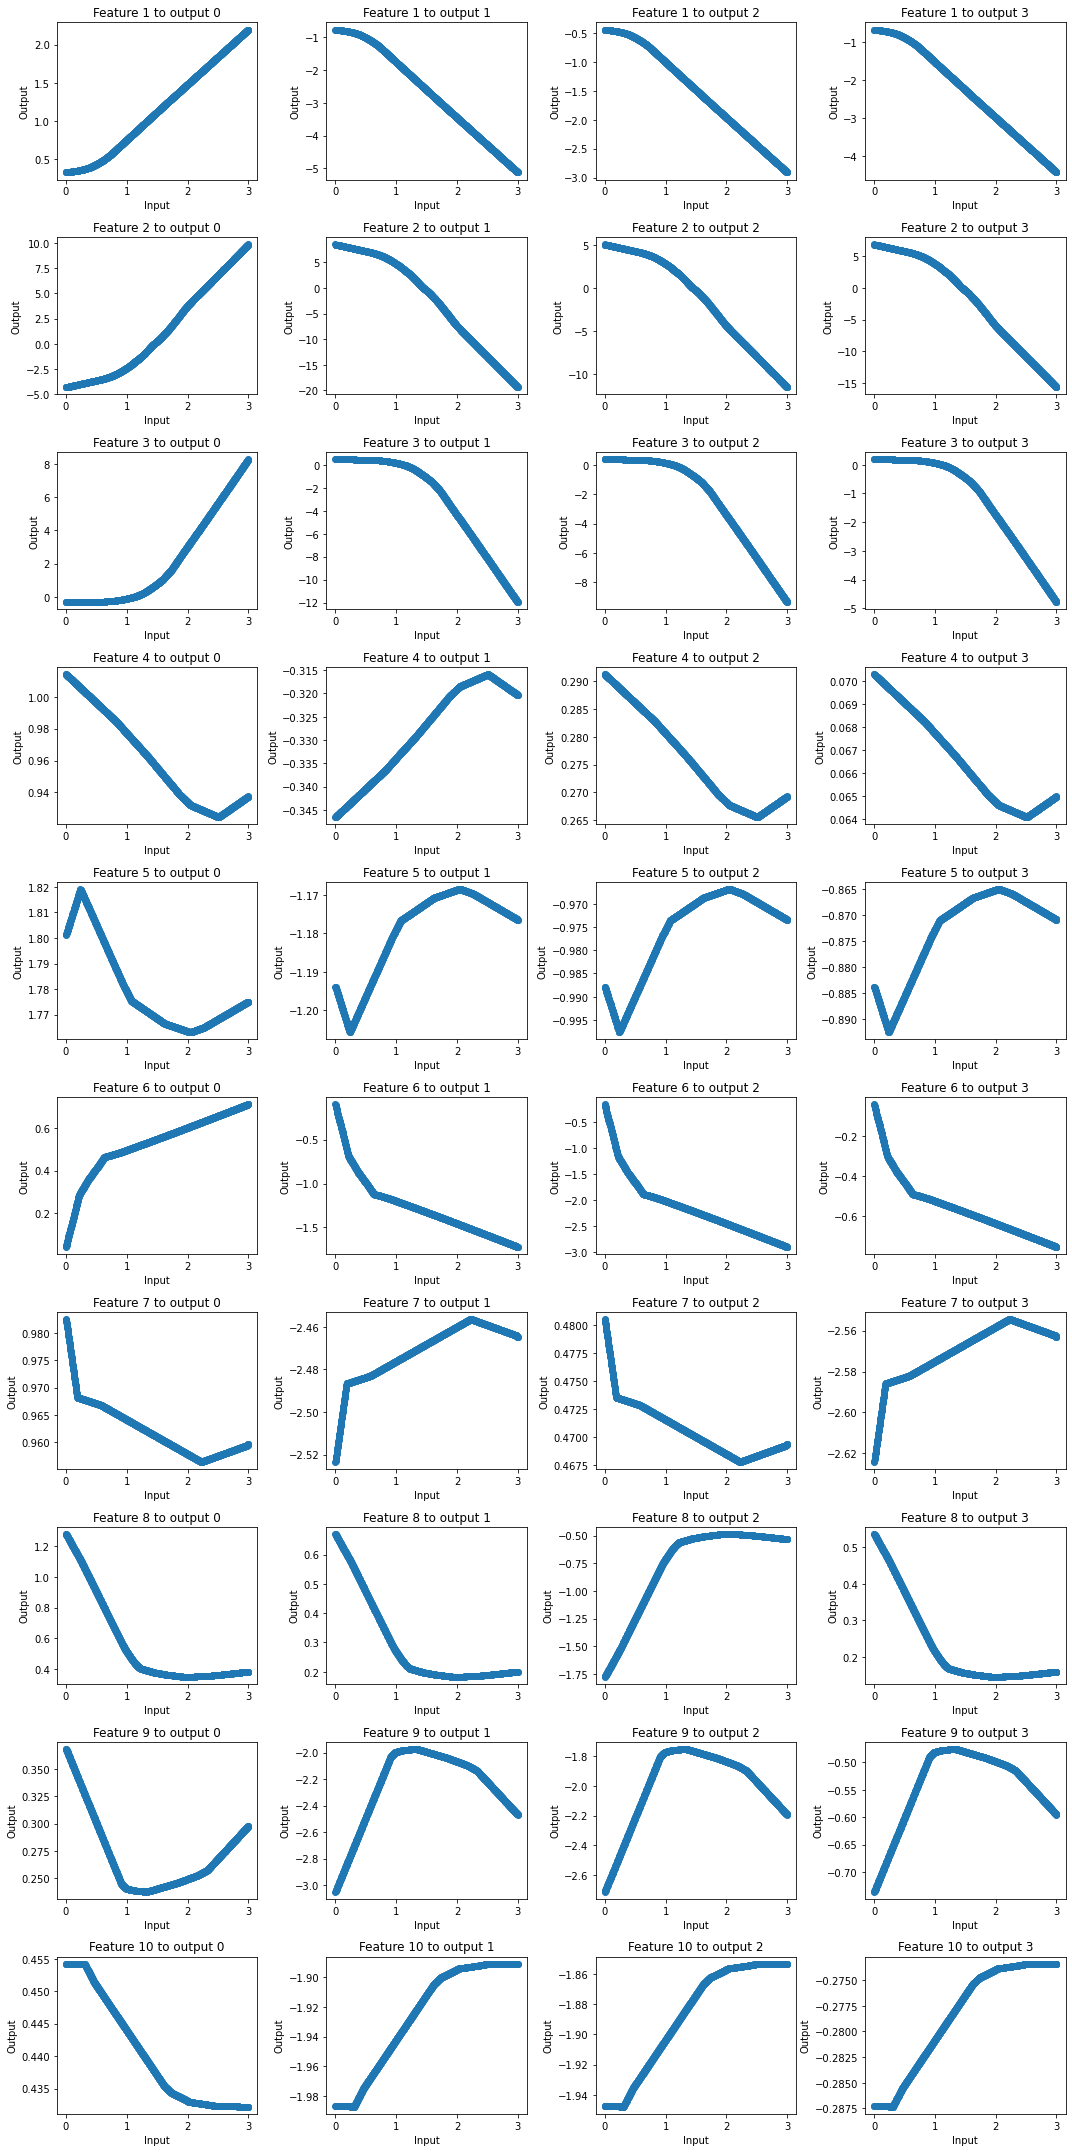

In [41]:
get_shape_functions(model, args)



In [15]:
def visualize_true_gam(input_dim, output_dim, shape_functions, x_values):
    
    # Plot learned functions
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15,30))

    for i in range(input_dim):
        for j in range(output_dim):
            ax1 = axes[i, j]
            feature_output = shape_functions[f'f_{j}_{i}']
                
            ax1.scatter(x_values, feature_output, label=f'Feature {i+1}')
            ax1.set_title(f'Feature {i+1} to output {j}')
            ax1.set_xlabel('Input')
            ax1.set_ylabel('Output')
            
    plt.tight_layout()
    plt.show()
    return

In [ ]:
num_test_exp=1000
X_in, y_phase1, shape_functions_phase1 = SyntheticDatasetGenerator.get_synthetic_data_phase1(num_test_exp, args.in_features, is_test=True)
y_phase2, shape_functions_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1, is_test=True)

x_values = torch.linspace(0, 3, num_test_exp).reshape(-1, 1)

input_dim = args.latent_dim
output_dim = args.output_dim
visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = False)

input_dim = args.in_features
output_dim = args.latent_dim
visualize_gam(model, x_values, input_dim, output_dim, vis_lat_features = True)

torch.Size([1000, 10])
torch.Size([1000, 4])
torch.Size([1000, 2])


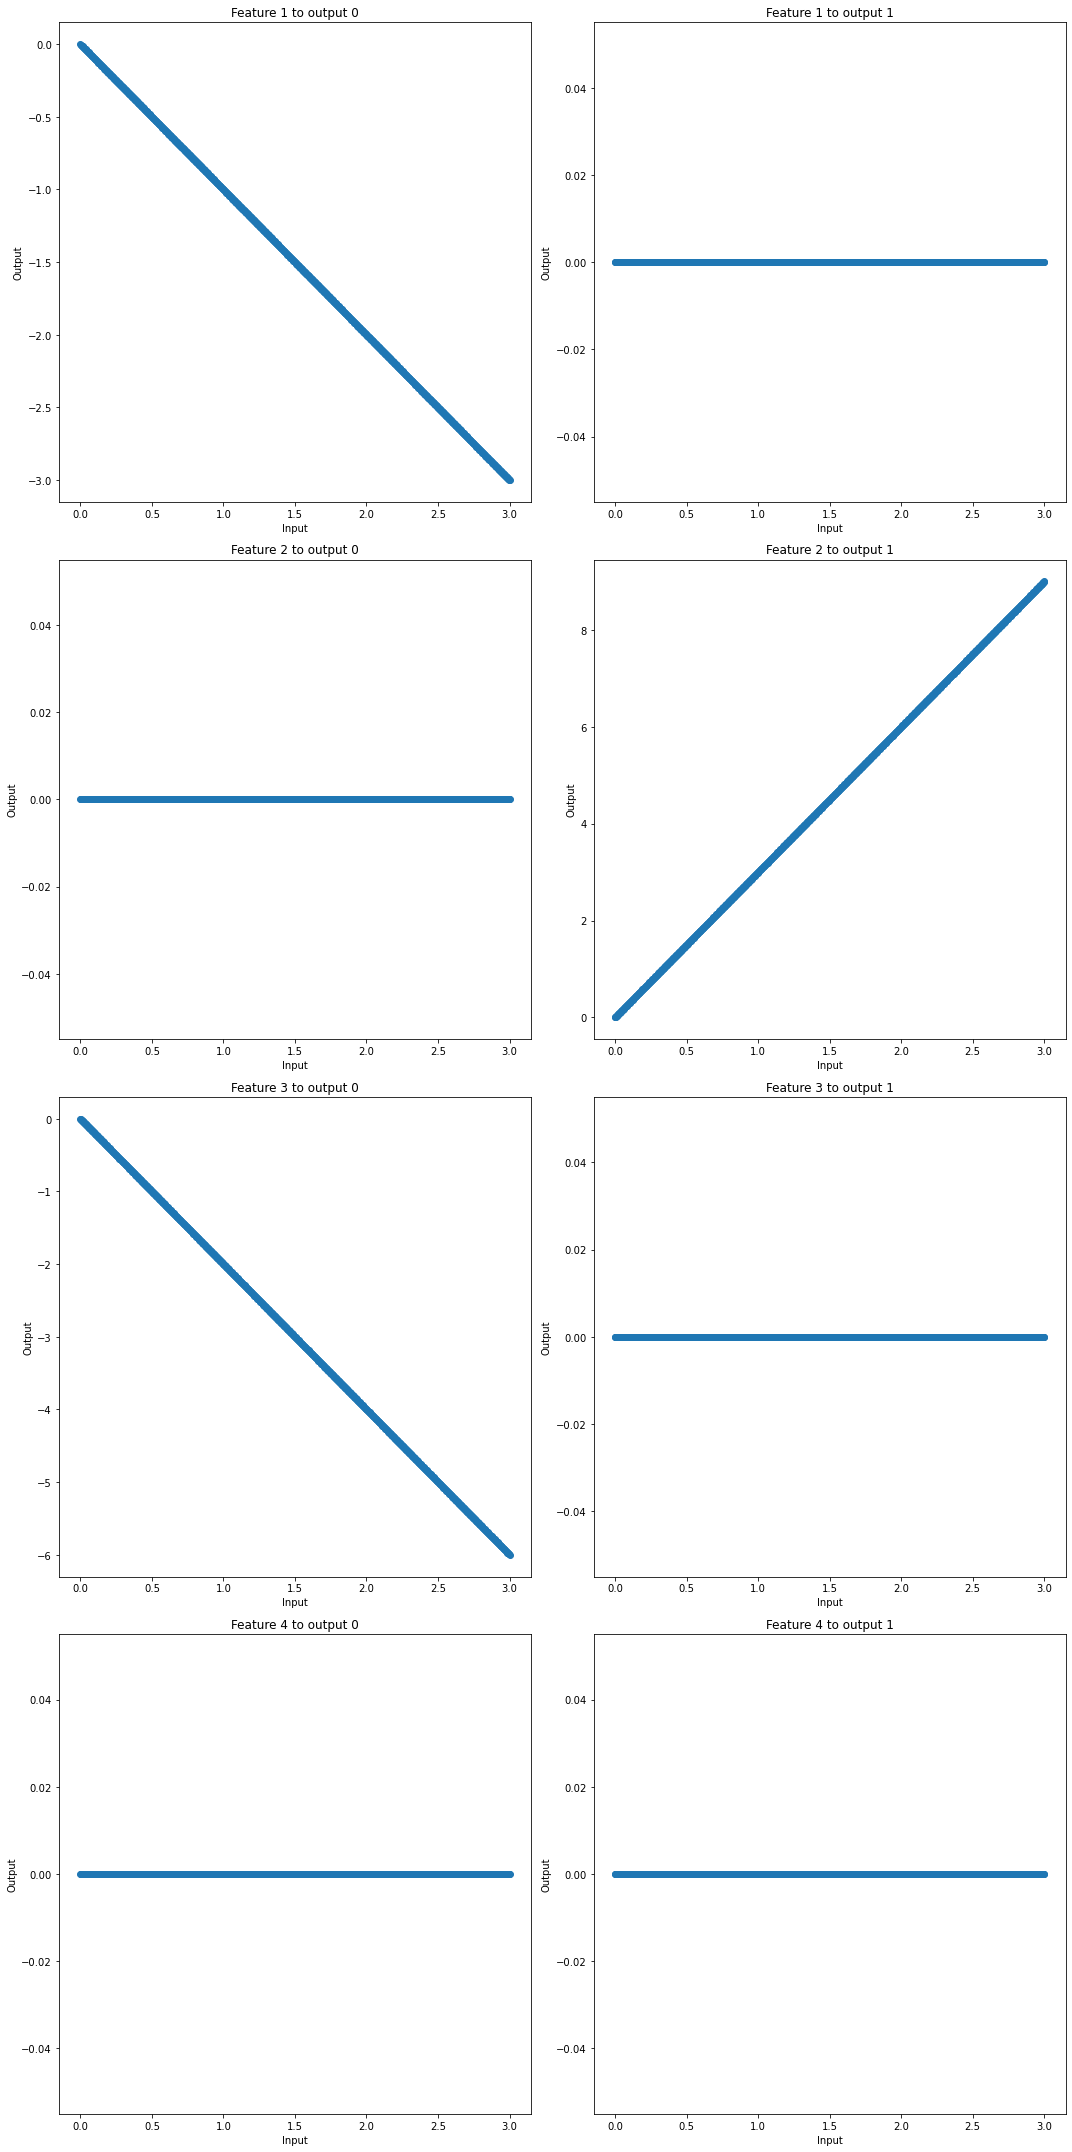

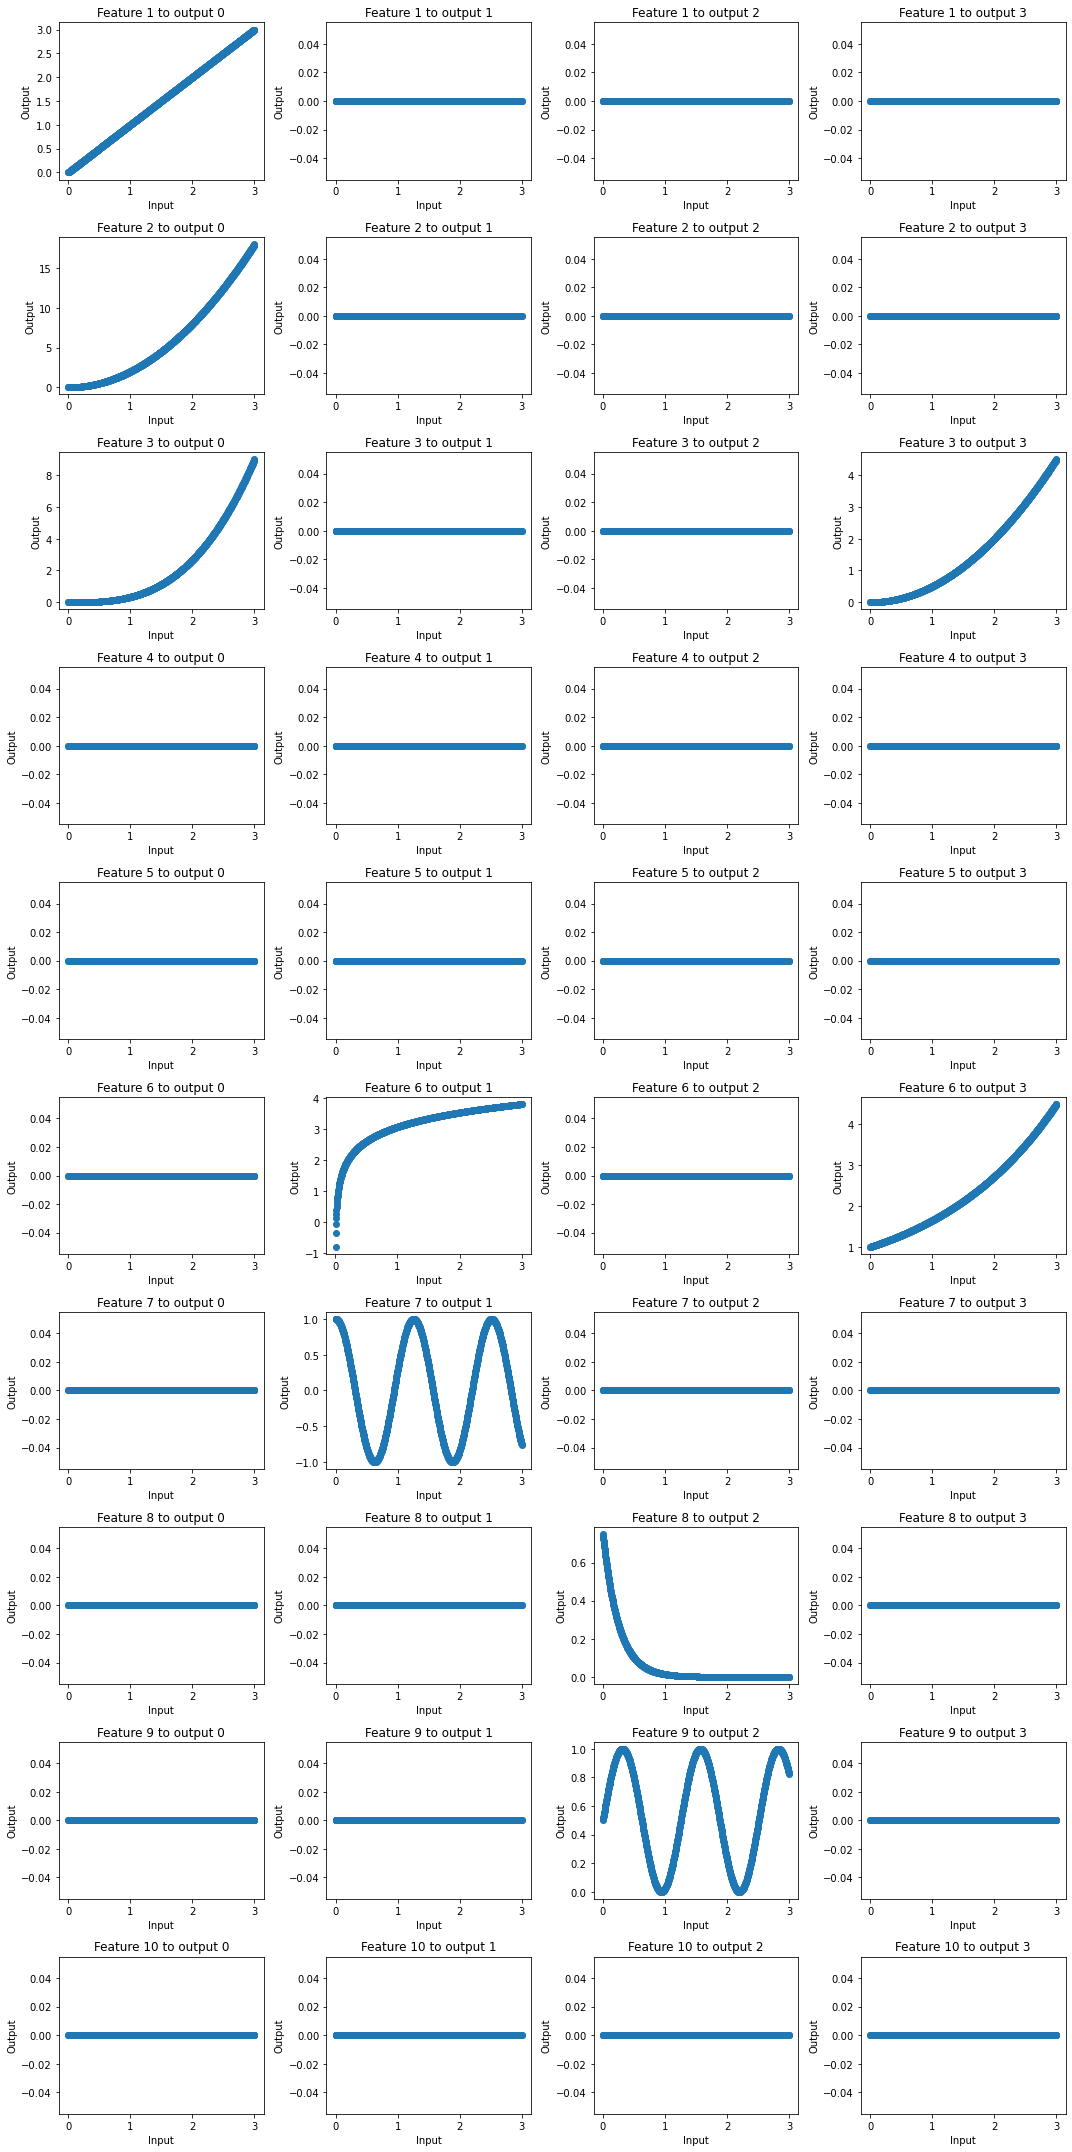

In [16]:
num_test_exp=1000
X_in, y_phase1, shape_functions_phase1 = SyntheticDatasetGenerator.get_synthetic_data_phase1(num_test_exp, args.in_features, is_test=True)
y_phase2, shape_functions_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1, is_test=True)

x_values = torch.linspace(0, 3, num_test_exp).reshape(-1, 1)

input_dim = args.latent_dim
output_dim = args.output_dim
visualize_true_gam(input_dim, output_dim, shape_functions_phase2, x_values)

input_dim = args.in_features
output_dim = args.latent_dim
visualize_true_gam(input_dim, output_dim, shape_functions_phase1, x_values)

In [43]:
import matplotlib.pyplot as plt

def visualize_combined_gam(model, x_values, input_dim, output_dim, shape_functions, vis_lat_features=False):
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get the device model is on

    x_values = x_values.to(device)
    
    # Plot learned and true functions
    fig, axes = plt.subplots(input_dim, output_dim, figsize=(15, 30))

    feature_output_max = {} 
    feature_output_min = {}

    for j in range(output_dim):
        feature_output_max[f'output_{j}'] = []
        feature_output_min[f'output_{j}'] = []

    for i in range(input_dim):
        with torch.no_grad():
            feature_input = x_values
            for j in range(output_dim):
                if model.hierarch_net:
                    if vis_lat_features:
                        feature_output = model.NAM_features.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                    else:
                        feature_output = model.NAM_output.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()
                else:
                    feature_output = model.feature_nns[i](feature_input[:, 0])[:, j].cpu().numpy()

                feature_output_max[f'output_{j}'].append(max(feature_output))
                feature_output_min[f'output_{j}'].append(min(feature_output))

                # Get the true shape function for this feature-output pair
                true_feature_output = shape_functions[f'f_{j}_{i}']

                # Plot the predicted shape function
                ax1 = axes[i, j]
                ax1.scatter(x_values.cpu().numpy(), feature_output, label=f'Predicted Feature {i+1}', color='blue', alpha=0.6)
                
                # Plot the true shape function
                ax1.plot(x_values.cpu().numpy(), true_feature_output, label=f'True Feature {i+1}', color='red', linestyle='--')

                # Set labels and title
                ax1.set_title(f'Feature {i+1} to output {j}')
                ax1.set_xlabel('Input')
                ax1.set_ylabel('Output')
                #ax1.set_ylim([min(feature_output_min[f'output_{j}'])*1.3, max(feature_output_max[f'output_{j}'])*1.3])

                # Add legend
                ax1.legend()

    plt.tight_layout()
    plt.show()

torch.Size([1000, 10])
torch.Size([1000, 4])
torch.Size([1000, 2])


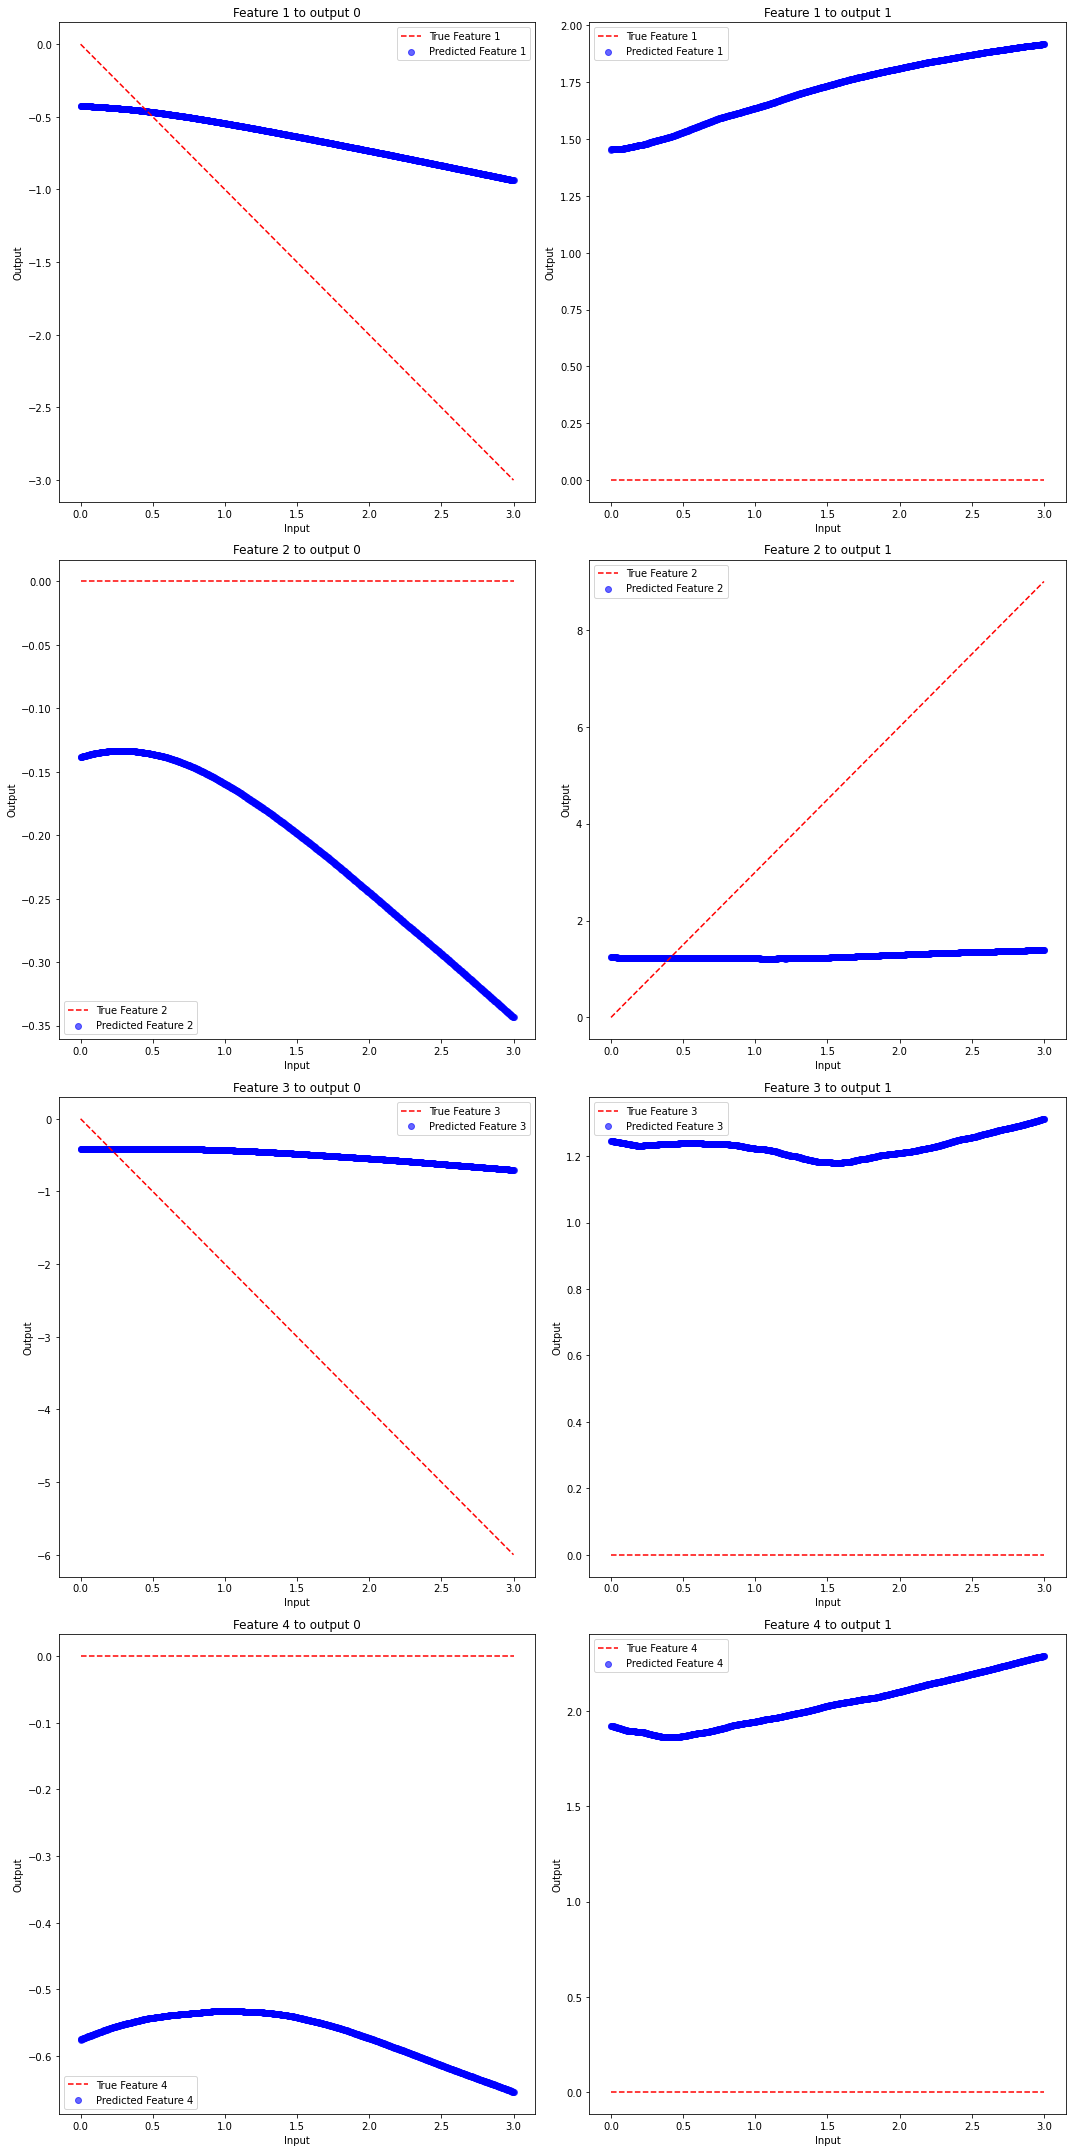

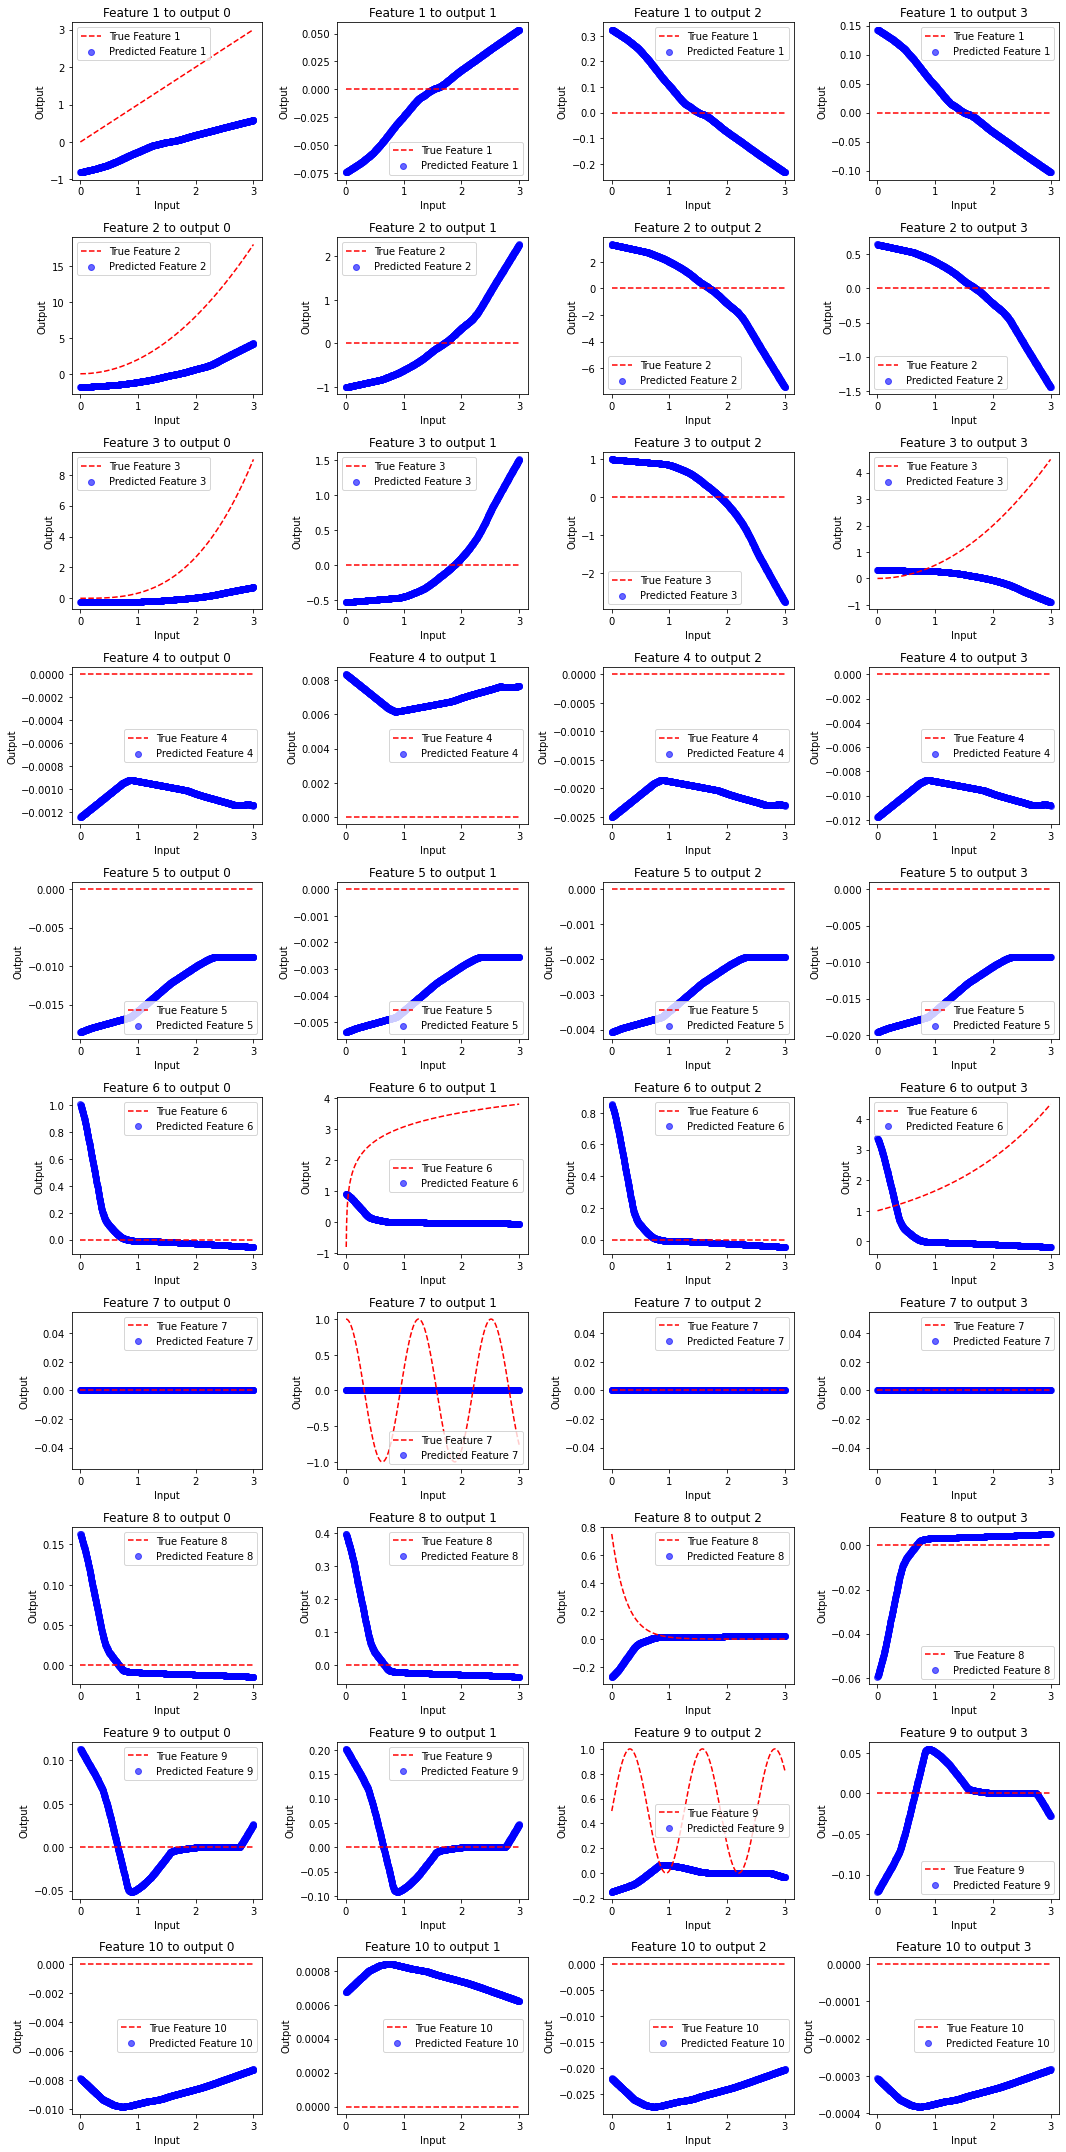

In [48]:
num_test_exp=1000
X_in, y_phase1, shape_functions_phase1 = SyntheticDatasetGenerator.get_synthetic_data_phase1(num_test_exp, args.in_features, is_test=True)
y_phase2, shape_functions_phase2 = SyntheticDatasetGenerator.get_synthetic_data_phase2(y_phase1, is_test=True)

x_values = torch.linspace(0, 3, num_test_exp).reshape(-1, 1)

input_dim = args.latent_dim
output_dim = args.output_dim
visualize_combined_gam(model, x_values, input_dim, output_dim, shape_functions_phase2)

input_dim = args.in_features
output_dim = args.latent_dim
visualize_combined_gam(model, x_values, input_dim, output_dim, shape_functions_phase1, vis_lat_features=True)
